<a href="https://colab.research.google.com/github/parthnaik13/MURA/blob/master/5_1_POC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC 2

In this notebook, we aim to follow along the footsteps of POC 1 to explore the relationship between race load that horses experience and its subsequent impact on their race performance (average race speed) using multi-variate modeling

## Things to look at in this modeling POC
* Do we directly model avg race speed or do we model the change in season avg for horses?
* Which confounding features to include?
* Do we get a good model?
* Do we see significance for race load features?
* Are the effects in the direction in which we would expect them to be?
* Can we quantify the effect of race load on avg race speed?
  * Ex - 14 more rest days lead to a 7.5% increase in avg race speed
  * Ex - 100 more furloghs lead to a 5% decrease in avg race speed

## Modeling steps

1. Load the nyra_race_horse_speed.csv data which is prepped in the `3.1_Data_Prep.ipynb` notebook
2. Create functions to calculate race-load features from the data
  * Cumulative volume in terms of race distance from season start
  * Avg rest intervals leading up to the race
3. Create feature buckets (allow for some non-linearity in the model)
3. Prepare the target
  * Let's try to model a ratio of $\frac{\text{Speed in current race for horse}_i}{\text{Avg speed across all races for horse}_i}$
4. Analyze prepped target (can we do a linear regression for the target, the target ratios should look like a normal distribution)
5. Filter data for modeling
  * Just the typical races i.e. 'D' (dirt) and 'FT' (fast) tracks (avoid adding in more features to the model at this stage to capture speed variations due to track types)
  * Filter out horses having less than 5 races (target maybe a bit unstable in these cases)
6. Separate out a holdout set (for model validation)
7. Fit a linear regression model
  * Target - current to avg speed ratio
  * Features
    * Odds
    * Weight carried
    * Race-load features
    * Race distance
    * Race purse
8. Look at the fitted model summary
9. Is the model better than a naive model (model always predicting a 1)?


## Setup

* Mount google drive
* Load necessary python libraries

In [1]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libs and print out their versions
import numpy as np
np.random.seed(7)

import pandas as pd
pd.set_option('display.max_columns', None) # Display all dataframe columns

import matplotlib
import matplotlib.pyplot as plt

import statsmodels
import sklearn

print(f'numpy version - {np.__version__}')
print(f'pandas version - {pd.__version__}')
print(f'matplotlib version - {matplotlib.__version__}')
print(f'statsmodels version- {statsmodels.__version__}')
print(f'sklearn version - {sklearn.__version__}')

numpy version - 1.21.6
pandas version - 1.3.5
matplotlib version - 3.2.2
statsmodels version- 0.12.2
sklearn version - 1.0.2


## Load prepped race data

Data prepped in the `3.1_Data_Prep.ipynb` notebook

In [3]:
# Load the data from the gdrive mount
nyra_df = pd.read_csv('/content/drive/MyDrive/NYRA_Data/nyra_race_horse_speed.csv', index_col = 0)
print(f'Shape of the dataframe - {nyra_df.shape}')
nyra_df.head(5)

Shape of the dataframe - (15080, 18)


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed
0,AQU,2019-01-01,1,3,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190
1,AQU,2019-01-01,1,4,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696
2,AQU,2019-01-01,1,5,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390
3,AQU,2019-01-01,1,1,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308
4,AQU,2019-01-01,1,2,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267


In [4]:
# Assign proper dtypes wherever needed
# Convert post_time to a datetime col (to extract the time part of things)
nyra_df['post_time'] = pd.to_datetime(nyra_df['post_time'])
# Incorporate the post time and convert this to a datetime column
nyra_df['race_date'] = pd.to_datetime(nyra_df['race_date'].astype(str) + ' ' + nyra_df['post_time'].dt.time.astype(str))
# post_time can now be dropped as its included in the race_date col
nyra_df = nyra_df.drop('post_time', axis = 1)
# race_number as a int/numeric col
nyra_df['race_number'] = pd.to_numeric(nyra_df['race_number'])

In [5]:
# Check of nulls (we don't have any, just in case)
nyra_df.isnull().sum().sum()

0

## Race load features
These features are indicative of the cumulative race load horses experience throughout the season

Brainstorm:
* Cumulative race distance (# of races ran since the start of the season)
* Avg # of days between races (experienced from the start of the season)
* Number of days/hours between previous and current race (did the horse get enough immediate rest)

### Calculate race load features

In [6]:
# Get race distance in miles
nyra_df['race_distance_miles'] = nyra_df['distance_id'] / 8 # Conversion of furlongs to miles
nyra_df['race_distance_miles'].describe()

count    15080.000000
mean        90.718667
std         18.820992
min         56.250000
25%         75.000000
50%         87.500000
75%        100.000000
max        250.000000
Name: race_distance_miles, dtype: float64

In [7]:
# Function to calculate cumulative race load which can be applied over horse groups
def race_load_features(horse_df):
  """
  Function to calculate
    * cumulative race distance given the race data for a horse
    * average time between races (in days)
    * time between the last and the current race
  
  Input: Horse race data (for a specific horse)

  Output: Race load features in the form of a dataframe (to be joined with the original df by index)

  Note: Race load features are at a race-level (calculated by looking at collective races for horses)
  """

  # Sort races by race_date
  horse_df = horse_df.sort_values(by = 'race_date', ascending = True)
  
  # Cumulative race distance

  # Get previous race distance col (we don't want to include the current race distance as the horse is yet to run)
  horse_df['prev_race_distance'] = horse_df['race_distance_miles'].shift(1)
  # Replace NaNs with 0s (first race of the season)
  horse_df = horse_df.fillna(0)
  # Get the cumulative previous race/s distance
  horse_df['cum_prev_race_distance'] = horse_df['prev_race_distance'].cumsum()

  # Get average time between races and the time from the last to current race (in days)

  # Get a previous race distance
  horse_df['prev_race_date'] = horse_df['race_date'].shift(1)
  horse_df['time_from_last_race'] = (horse_df['race_date'] - horse_df['prev_race_date']).dt.days
  # Fill NaNs with 0s (first race of the season doesn't have a previous race)
  horse_df = horse_df.fillna(0)
  # Get average of the all the previous time_from_last_race for a horse
  horse_df['prev_race_count'] = [i for i in range(0, horse_df.shape[0])]
  horse_df['time_from_last_race_cumsum'] = horse_df['time_from_last_race'].cumsum()
  horse_df['avg_time_from_last_race'] = horse_df['time_from_last_race_cumsum'] / horse_df['prev_race_count']
  horse_df['avg_time_from_last_race'] = horse_df['avg_time_from_last_race'].fillna(0) # For the first race of the race season for the horse

  return horse_df[['cum_prev_race_distance', 'avg_time_from_last_race', 'time_from_last_race']]

In [8]:
# Get the cum_prev_race_distance for horses across races using the above function (join with nyra_df using the index)
race_load_df = nyra_df.groupby('horse_id').apply(race_load_features).reset_index().set_index('level_1')
# Shape of the df
print(f'Shape of the df - {race_load_df.shape}')
race_load_df.head(5)

Shape of the df - (15080, 4)


,horse_id,cum_prev_race_distance,avg_time_from_last_race,time_from_last_race
level_1,,,,
2,0,0.00,0.000000,0.0
7570,0,81.25,145.000000,145.0
8444,0,181.25,82.000000,19.0
12474,0,256.25,66.666667,36.0
13907,0,325.00,56.000000,24.0


In [9]:
# Look for nulls in the race_load_df
race_load_df.isnull().sum().sum()

0

### Look at the distributions of the race load features

count    15080.000000
mean       202.500000
std        238.537386
min          0.000000
25%          0.000000
50%        112.500000
75%        306.250000
max       1762.500000
Name: cum_prev_race_distance, dtype: float64


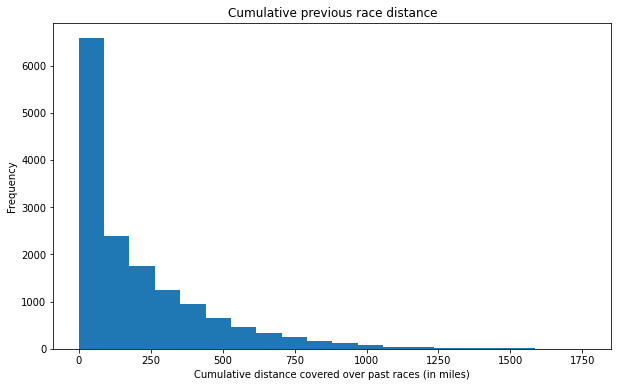

In [10]:
# Cumulative distance covered in the previous races
print(race_load_df['cum_prev_race_distance'].describe())
# Generate the plot
plt.figure(figsize = (10,6))
plt.hist(race_load_df['cum_prev_race_distance'], bins = 20)
plt.xlabel('Cumulative distance covered over past races (in miles)')
plt.ylabel('Frequency')
plt.title('Cumulative previous race distance')
plt.show()

count    15080.000000
mean        25.970114
std         27.022233
min          0.000000
25%          0.000000
50%         25.000000
75%         36.666667
max        336.000000
Name: avg_time_from_last_race, dtype: float64


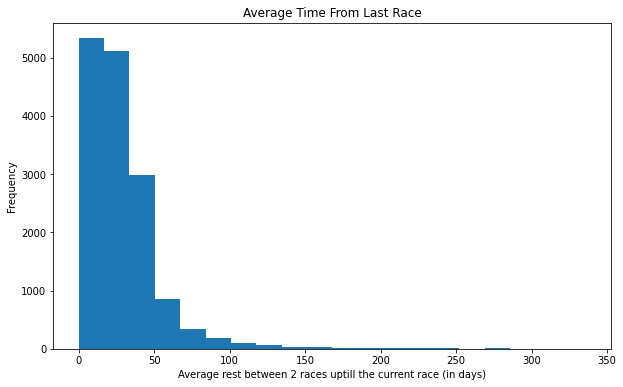

In [11]:
# Average rest time (avg_time_from_last_race)
print(race_load_df['avg_time_from_last_race'].describe())
# Generate the plot
plt.figure(figsize = (10,6))
plt.hist(race_load_df['avg_time_from_last_race'], bins = 20)
plt.xlabel('Average rest between 2 races uptill the current race (in days)')
plt.ylabel('Frequency')
plt.title('Average Time From Last Race')
plt.show()

count    15080.000000
mean        26.405637
std         33.140778
min          0.000000
25%          0.000000
50%         21.000000
75%         35.000000
max        347.000000
Name: time_from_last_race, dtype: float64


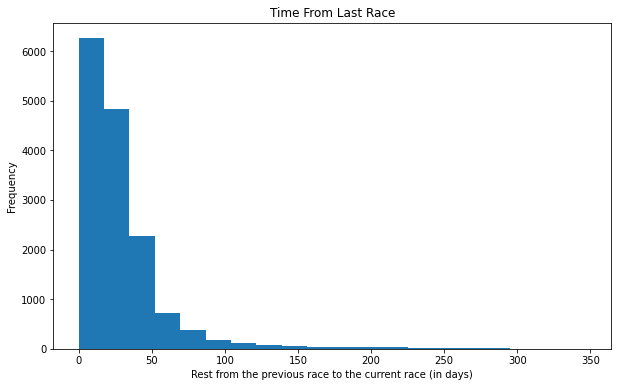

In [12]:
# Rest time since the last race (time_from_last_race)
print(race_load_df['time_from_last_race'].describe())
# Generate the plot
plt.figure(figsize = (10,6))
plt.hist(race_load_df['time_from_last_race'], bins = 20)
plt.xlabel('Rest from the previous race to the current race (in days)')
plt.ylabel('Frequency')
plt.title('Time From Last Race')
plt.show()

### Join the race load features with the main df

In [13]:
# Join race_load_df and nyra_df on the index
nyra_df = nyra_df.join(race_load_df[['cum_prev_race_distance', 'avg_time_from_last_race', 'time_from_last_race']], how = 'inner')
# Look at the shape of the df
print(f'Shape of the df - {nyra_df.shape}')
# Check for nulls
print(f'Nulls - {nyra_df.isnull().sum().sum()}')
nyra_df.head(5)

Shape of the df - (15080, 21)
Nulls - 0


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed,race_distance_miles,cum_prev_race_distance,avg_time_from_last_race,time_from_last_race
0,AQU,2019-01-01 12:20:00,1,3,650,D,MY,36,AOC,80000,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190,81.25,0.0,0.0,0.0
1,AQU,2019-01-01 12:20:00,1,4,650,D,MY,36,AOC,80000,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696,81.25,0.0,0.0,0.0
2,AQU,2019-01-01 12:20:00,1,5,650,D,MY,36,AOC,80000,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390,81.25,0.0,0.0,0.0
3,AQU,2019-01-01 12:20:00,1,1,650,D,MY,36,AOC,80000,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308,81.25,0.0,0.0,0.0
4,AQU,2019-01-01 12:20:00,1,2,650,D,MY,36,AOC,80000,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267,81.25,0.0,0.0,0.0


## Bucket the race load features

Creating feature buckets allows for non-linearity in our linear regression model, we potentially need this non-linearity to capture effects such as increase in horse speed with increase in races to a point after which too many races cause fatigue and we start to see horse's performance diminish further

In [14]:
# Let's start by creating bins having widths of 250 miles
nyra_df['cum_prev_race_distance_bins'] = pd.cut(
    nyra_df['cum_prev_race_distance'],
    bins = [0, 250, 500, 750, 1000, 2000],
    include_lowest = True
).astype(str)

# Rename the first bin to be [0, 250] instead of the (-0.001, 250]
nyra_df.loc[
    nyra_df['cum_prev_race_distance_bins'] == '(-0.001, 250.0]',
    'cum_prev_race_distance_bins'
] = '0_250'
# Rename rest of the columns to play well with statsmodels
nyra_df.loc[
    nyra_df['cum_prev_race_distance_bins'] == '(250.0, 500.0]',
    'cum_prev_race_distance_bins'
] = '251_500'
nyra_df.loc[
    nyra_df['cum_prev_race_distance_bins'] == '(500.0, 750.0]',
    'cum_prev_race_distance_bins'
] = '500_750'
nyra_df.loc[
    nyra_df['cum_prev_race_distance_bins'] == '(750.0, 1000.0]',
    'cum_prev_race_distance_bins'
] = '751_1000'
nyra_df.loc[
    nyra_df['cum_prev_race_distance_bins'] == '(1000.0, 2000.0]',
    'cum_prev_race_distance_bins'
] = '1001_2000'


# Distribution of races across the bins 
(nyra_df['cum_prev_race_distance_bins'].value_counts() / nyra_df.shape[0]) * 100

0_250        70.179045
251_500      18.547745
500_750       7.519894
751_1000      2.553050
1001_2000     1.200265
Name: cum_prev_race_distance_bins, dtype: float64

In [15]:
# Create one-hot encoding for the cum_prev_race_distance_bins column
nyra_df = pd.get_dummies(nyra_df, columns = ['cum_prev_race_distance_bins'])
# Drop the [0, 250] bucket (this will be our base level)
nyra_df = nyra_df.drop('cum_prev_race_distance_bins_0_250', axis = 1)
# Rename dummies to play well 
nyra_df.head(5)

,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed,race_distance_miles,cum_prev_race_distance,avg_time_from_last_race,time_from_last_race,cum_prev_race_distance_bins_1001_2000,cum_prev_race_distance_bins_251_500,cum_prev_race_distance_bins_500_750,cum_prev_race_distance_bins_751_1000
0,AQU,2019-01-01 12:20:00,1,3,650,D,MY,36,AOC,80000,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190,81.25,0.0,0.0,0.0,0,0,0,0
1,AQU,2019-01-01 12:20:00,1,4,650,D,MY,36,AOC,80000,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696,81.25,0.0,0.0,0.0,0,0,0,0
2,AQU,2019-01-01 12:20:00,1,5,650,D,MY,36,AOC,80000,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390,81.25,0.0,0.0,0.0,0,0,0,0
3,AQU,2019-01-01 12:20:00,1,1,650,D,MY,36,AOC,80000,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308,81.25,0.0,0.0,0.0,0,0,0,0
4,AQU,2019-01-01 12:20:00,1,2,650,D,MY,36,AOC,80000,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267,81.25,0.0,0.0,0.0,0,0,0,0


## Prepare the target

$Target = \frac{\text{Speed in current race for horse}_i}{\text{Avg speed across all races for horse}_i}$

* In order to account for the change in speed rather than just the race speed which can vary by horses, we model the ratio of the race speed for a horse to the average speed we recorded for that horse
* So a 0.8 target would indicate that $horse_i$ was 20% slower than its average speed in the race of interest

In [16]:
# Get the average speeds for horses across races
horse_avg_speeds_df = nyra_df.groupby('horse_id').agg({'avg_race_speed' : 'mean', 'race_number' : 'count'}).reset_index()
horse_avg_speeds_df = horse_avg_speeds_df.rename(columns = {'avg_race_speed' : 'avg_horse_speed', 'race_number' : 'race_count' })
# Merge with nyra_df
nyra_df = nyra_df.merge(horse_avg_speeds_df, how = 'left', on = 'horse_id')

(array([7.000e+00, 0.000e+00, 1.000e+00, 7.000e+00, 8.000e+00, 9.000e+00,
        2.600e+01, 7.200e+01, 1.670e+02, 3.920e+02, 8.700e+02, 1.330e+03,
        1.071e+03, 4.310e+02, 1.200e+02, 4.800e+01, 2.000e+01, 5.000e+00,
        1.100e+01, 4.300e+01]),
 array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
        43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 20 Patch objects>)

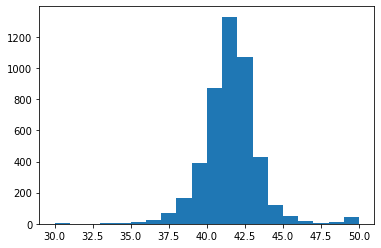

In [19]:
plt.hist(np.clip(horse_avg_speeds_df['avg_horse_speed'], a_min = 30, a_max = 50), bins = 20)

In [237]:
# Calculate target
nyra_df['target'] = nyra_df['avg_race_speed'] / nyra_df['avg_horse_speed']
# Target desccription
print(nyra_df['target'].describe())

count    15080.000000
mean         1.000000
std          0.085408
min          0.257663
25%          0.982994
50%          1.000000
75%          1.015977
max          4.416183
Name: target, dtype: float64


count    15080.000000
mean         0.997289
std          0.037465
min          0.834461
25%          0.982994
50%          1.000000
75%          1.015977
max          1.118229
Name: target, dtype: float64


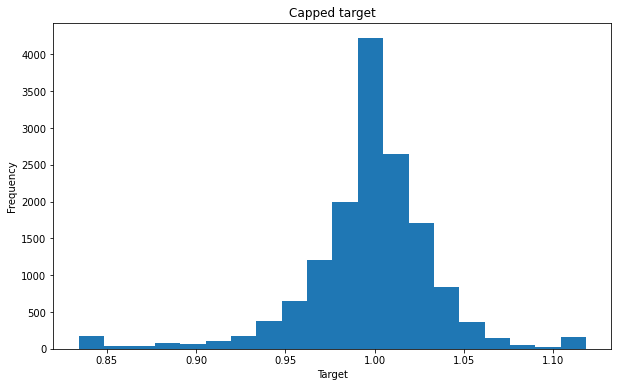

In [238]:
# Capping the target at the 95% percentile (ceil) and 1% percentile (floor)
nyra_df['target'] = np.clip(nyra_df['target'], a_min = np.quantile(nyra_df['target'], 0.01), a_max = np.quantile(nyra_df['target'], 0.99))
# Distribution of the target after capping
print(nyra_df['target'].describe())
# Histogram
plt.figure(figsize = (10,6))
plt.hist(nyra_df['target'], bins = 20)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Capped target')
plt.show()

* The capped target appears to be somewhat normal (which we would expect) with a slightly longer tail towards the lower values
* At max we see a 17% reduction in avg speed
* At max we see a 11% improvement in avg speed

We should plan to eliminate horses having fewer than 5 races as the avg horse speed and hence the target would be unstable with lesser number of races (samples)

## Filter data for modeling

In [239]:
# # Filter to just the typical races i.e. dirt and fast type of track conditions
# nyra_modeling_df = nyra_df.loc[
#     (nyra_df['course_type'] == 'D') &
#     (nyra_df['track_condition'] == 'FT '),
#     :
# ].copy()
# # Look at the shape of the df
# nyra_modeling_df.shape

In [269]:
# Filter out horses having less than 5 races
nyra_modeling_df = nyra_df.loc[
    (nyra_df['race_count'] >= 5),
    #(nyra_df['course_type'] == 'D'),
    :
].copy()
# Look at the shape of the df
nyra_modeling_df.shape

(7959, 28)

## Select features for modeling

In [270]:
# Columns in the df
nyra_modeling_df.columns

Index(['track_id', 'race_date', 'race_number', 'program_number', 'distance_id',
       'course_type', 'track_condition', 'run_up_distance', 'race_type',
       'purse', 'weight_carried', 'jockey', 'odds', 'horse_id',
       'finishing_place', 'horse_name', 'avg_race_speed',
       'race_distance_miles', 'cum_prev_race_distance',
       'avg_time_from_last_race', 'time_from_last_race',
       'cum_prev_race_distance_bins_1001_2000',
       'cum_prev_race_distance_bins_251_500',
       'cum_prev_race_distance_bins_500_750',
       'cum_prev_race_distance_bins_751_1000', 'avg_horse_speed', 'race_count',
       'target'],
      dtype='object')

In [277]:
# Select features and the target to use
features = [
    'weight_carried', 'odds', 'avg_time_from_last_race', 'race_distance_miles', 'purse', 'run_up_distance',
    'cum_prev_race_distance_bins_1001_2000', 'cum_prev_race_distance_bins_251_500', 'cum_prev_race_distance_bins_500_750', 'cum_prev_race_distance_bins_751_1000',
    'race_count'
]  # 'time_from_last_race'

target = ['target']

Exploring modeling excitement lol!

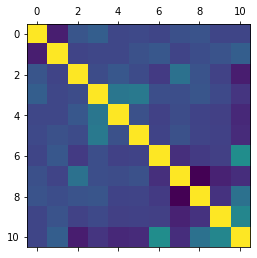

In [278]:
plt.matshow(nyra_modeling_df[features].corr())
plt.show()

In [279]:
formula = 'target ~ ' + ' + '.join(features) + ' + cum_prev_race_distance_bins_751_1000 * avg_time_from_last_race + cum_prev_race_distance_bins_1001_2000 * avg_time_from_last_race + cum_prev_race_distance_bins_251_500 *  avg_time_from_last_race + cum_prev_race_distance_bins_500_750 * avg_time_from_last_race'
print(formula)

target ~ weight_carried + odds + avg_time_from_last_race + race_distance_miles + purse + run_up_distance + cum_prev_race_distance_bins_1001_2000 + cum_prev_race_distance_bins_251_500 + cum_prev_race_distance_bins_500_750 + cum_prev_race_distance_bins_751_1000 + race_count + cum_prev_race_distance_bins_751_1000 * avg_time_from_last_race + cum_prev_race_distance_bins_1001_2000 * avg_time_from_last_race + cum_prev_race_distance_bins_251_500 *  avg_time_from_last_race + cum_prev_race_distance_bins_500_750 * avg_time_from_last_race


In [280]:
import statsmodels.formula.api as smf

model = smf.ols(formula = formula, data = nyra_modeling_df).fit()

# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     37.76
Date:                Thu, 08 Sep 2022   Prob (F-statistic):          4.78e-107
Time:                        03:34:07   Log-Likelihood:                 14002.
No. Observations:                7959   AIC:                        -2.797e+04
Df Residuals:                    7943   BIC:                        -2.786e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [275]:
from sklearn.ensemble import RandomForestRegressor

test_model = RandomForestRegressor()

test_model = test_model.fit(nyra_modeling_df[features], nyra_modeling_df[target])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


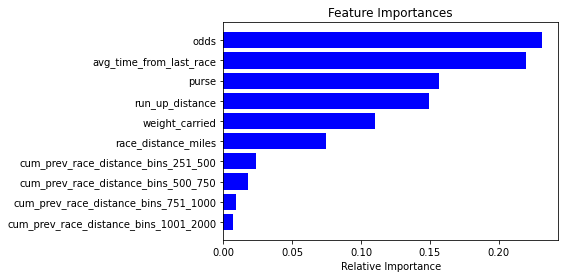

In [276]:
features = features
importances = test_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [257]:
mape(nyra_modeling_df['target'], test_model.predict(nyra_modeling_df[features])) * 100

1.1104690916348134

In [254]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

mape(nyra_modeling_df['target'], model.predict(nyra_modeling_df)) * 100
#mae(nyra_modeling_df['target'], model.predict(nyra_modeling_df)) * 100

2.9815188981115748

In [ ]:
nyra_modeling_df.iloc[2,:]

weight_carried             121.000000
odds                       580.000000
cum_prev_race_distance     100.000000
avg_time_from_last_race      7.000000
target                       1.022828
Name: 362, dtype: float64

In [ ]:
nyra_modeling_df.iloc[3,:]

weight_carried             122.000000
odds                       950.000000
cum_prev_race_distance      87.500000
avg_time_from_last_race      9.000000
target                       1.000626
Name: 396, dtype: float64

In [ ]:
model.predict(nyra_modeling_df).iloc[2]

0.986353001375075

In [258]:
mape(nyra_modeling_df['target'], [1 for i in range(nyra_modeling_df.shape[0])]) * 100
#mae(nyra_modeling_df['target'], [1 for i in range(nyra_modeling_df.shape[0])]) * 100

3.1665237830304087

## Get a holdout set

In [ ]:
# Use sklearn functions for getting the holdout set

In [ ]:
print('I\'m alive')

I'm alive


In [173]:
nyra_df.columns

Index(['track_id', 'race_date', 'race_number', 'program_number', 'distance_id',
       'course_type', 'track_condition', 'run_up_distance', 'race_type',
       'purse', 'weight_carried', 'jockey', 'odds', 'horse_id',
       'finishing_place', 'horse_name', 'avg_race_speed',
       'race_distance_miles', 'cum_prev_race_distance',
       'avg_time_from_last_race', 'time_from_last_race',
       'cum_prev_race_distance_bins_1000_2000',
       'cum_prev_race_distance_bins_251_500',
       'cum_prev_race_distance_bins_500_750',
       'cum_prev_race_distance_bins_751_1000', 'avg_horse_speed', 'race_count',
       'target'],
      dtype='object')

In [176]:
nyra_df.groupby(nyra_df['course_type']).agg({'avg_race_speed' : 'mean', 'race_number' : 'count'}).reset_index()

,course_type,avg_race_speed,race_number
0,D,41.257293,9570
1,I,42.766970,2002
2,M,38.590039,76
3,O,42.434696,621
4,T,43.047329,2811
